In [1]:
#!/usr/bin/env python

import numpy as np
import scipy as scipy
import sys
import copy
import myfun as mf
import networkx as nx

import matplotlib
from matplotlib import gridspec, rc
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt

rc('text',usetex=False)

# Needs: 
# pseudotime trajectory
# eigenvalues as function of time
# gexp for neutrophil genes
# gexp for myelocite genes

In [2]:
headdir    = '.' #'/Users/simonfreedman/cqub/bifurc/weinreb_2020/'
figdir     = '{0}/figs'.format(headdir)
datdir     = '{0}/neutrophil_data'.format(headdir)
#corr_dir   = '{0}/corr/min_nc9_gexp_0'.format(datdir)
corr_dir   = '{0}/corr_nc400'.format(datdir)

gexp_fname = '{0}/gene_expr.npz'.format(datdir)
pst_fname  = '{0}/pseudotime.txt'.format(datdir)
gnm_fname  = '{0}/gene_names.txt'.format(datdir)
meta_fname = '{0}/metadata.txt'.format(datdir)

In [3]:
# In[6]:

print('loading gene expression matrix')
gexp_sp    = scipy.sparse.load_npz(gexp_fname) # WT: 18.3 seconds
gexp_lil   = gexp_sp.tolil() # WT: 3 min 55 seconds

# In[4]:
gnms     = np.genfromtxt(gnm_fname,dtype='str')


# In[5]:
neut_psts = np.genfromtxt(pst_fname, skip_header=True, dtype='int')
bin_sz            = 1000
overlap           = int(bin_sz/2)

srt               = np.argsort(neut_psts[:,1])
last_full_bin     = int(np.floor(srt.shape[0]/overlap)*overlap) - bin_sz + overlap
neut_pst_grps     = [srt[i:(i+bin_sz)] for i in range(0,last_full_bin,overlap)]
neut_pst_grps[-1] = np.union1d(neut_pst_grps[-1], srt[last_full_bin:])
neut_pst_cidxs    = [np.array(neut_psts[grp,0], dtype = 'int') for grp in neut_pst_grps]
npsts             = len(neut_pst_cidxs)

# In[6]:

pst_eig1 = np.load('{0}/eig/dat_eval.npy'.format(datdir))[:,0]
tf       = pst_eig1.shape[0]
bift     = np.argmax(pst_eig1)
ti       = 2*bift - tf

loading gene expression matrix


In [4]:
# In[8]:
binmin         = -1
binmax         = 1
dbin           = 0.05
corr_bin_edges = np.arange(binmin-dbin/2,binmax+dbin,dbin)
corr_bin_ctrs  = 0.5*(corr_bin_edges[1:]+corr_bin_edges[:-1])
corr_nbin      = corr_bin_ctrs.shape[0]

nc_thresh    = 400
thresh_hists = np.zeros((tf-ti, corr_nbin))

for t in range(ti,tf):
    corrs                = np.load('{0}/pccs_{1}.npy'.format(    corr_dir, t))
    gidxs_nc             = np.load('{0}/gidxs_nc_{1}.npy'.format(corr_dir, t))
    corr_idxs            = np.where(gidxs_nc[:,2]>=nc_thresh)[0]
    thresh_hists[t-ti]   = np.histogram(corrs[corr_idxs], bins = corr_bin_edges, density=True)[0]

# gene graph

t = bift
corr_hi_thresh = 0.65
corr_lo_thresh = -0.3
corrs_bi    = np.load('{0}/pccs_{1}.npy'.format(corr_dir, t))
gidxs_nc_bi = np.load('{0}/gidxs_nc_{1}.npy'.format(corr_dir, t))


# In[14]:
hi_pos_corr_bi_cidxs = np.where((corrs_bi>corr_hi_thresh) & (gidxs_nc_bi[:,2]>=nc_thresh))[0]
hi_neg_corr_bi_cidxs = np.where((corrs_bi<corr_lo_thresh) & (gidxs_nc_bi[:,2]>=nc_thresh))[0]
hi_corr_bi_cidxs     = np.hstack([hi_pos_corr_bi_cidxs,hi_neg_corr_bi_cidxs])

hi_pos_corr_bi_gidxs = gidxs_nc_bi[hi_pos_corr_bi_cidxs,0:2]
hi_neg_corr_bi_gidxs = gidxs_nc_bi[hi_neg_corr_bi_cidxs,0:2]
hi_corr_bi_gidxs     = np.vstack([hi_pos_corr_bi_gidxs, hi_neg_corr_bi_gidxs])

hi_corr_bi_gidxs_unq = np.unique(hi_corr_bi_gidxs.reshape(-1))



# In[19]:
gidx_dict = {gnms[i].lower():i for i in range(len(gnms))}

In [5]:
# In[55]:

# genes listed in weinreb2020

neut_gnms        = np.array(['S100a9', 'Itgb2l', 'Elane', 'Fcnb', 'Mpo', 'Prtn3', 
                              'S100a6', 'S100a8', 'Lcn2', 'Lrg1'])
mpp_gnms         = np.array(['Ly6a','Meis1','Flt3','Cd34'])
gpp_gnms         = np.array(['Csf1r','Cebpa'])
pmy_gnms         = np.array(['Gfi1','Elane'])
my_gnms          = np.array(['S100a8','Ngp','Ltf'])

weinreb_gnms  = set([k.lower() for k in mf.flatten2d([neut_gnms, mpp_gnms, gpp_gnms, pmy_gnms, my_gnms])])



# In[48]:
housekeeping = ['cstb','ctsd','fth1']
myeloid      = ['ngp', 's100a8'] 
neutrophil   = ['s100a6','s100a9','lcn2','ccl6'] 
membrane     = ['rab7','anxa4','cd9']
metabolism   = ['psap','laptm5','sat1','gstm1','sqstm1','ctsb','ftl1','sirpa']
sig_dev      = ['sdcbp','bri3','plin2','cybb','srgn']
mitochon     = ['mt-cytb','mt-atp6','mt-co2']
misc         = ['h3f3a','mpeg1','h2-d1']

gtype_nms = ['membrane','metabolism', 'neutrophil','housekeep','mitochondria', 
          'misc', 'signalling', 'myelocyte']
gtypes = [membrane, metabolism, neutrophil, housekeeping, mitochon, misc, sig_dev, myeloid]

gtype_dict = {}
gtype_gidx_dict = {}
for i in range(len(gtypes)):
    for gn in gtypes[i]:
        gtype_dict[gn] = i

# In[50]: grpaph building


gnms_net = nx.Graph()
gnms0   = [x.lower() for x in gnms[gidxs_nc_bi[hi_corr_bi_cidxs,0]]]
gnms1   = [x.lower() for x in gnms[gidxs_nc_bi[hi_corr_bi_cidxs,1]]]

edg_wts       = corrs_bi[hi_corr_bi_cidxs]
pos_corr_idxs = np.where(edg_wts  > 0)[0]
neg_corr_idxs = np.where(edg_wts <= 0)[0]

edg_wts_pos   = edg_wts[pos_corr_idxs]
edg_wts_neg   = edg_wts[neg_corr_idxs]

edg_wts_pos_normd = (edg_wts_pos - np.min(edg_wts_pos)) / (np.amax(edg_wts_pos) - np.amin(edg_wts_pos))
edg_wts_neg_normd = (edg_wts_neg - np.min(edg_wts_neg)) / (np.amax(edg_wts_neg) - np.amin(edg_wts_neg))

edg_wts_normd = np.zeros(edg_wts.shape[0])
for i in range(len(pos_corr_idxs)):
    edg_wts_normd[pos_corr_idxs[i]] = edg_wts_pos_normd[i]
for i in range(len(neg_corr_idxs)):
    edg_wts_normd[neg_corr_idxs[i]] = edg_wts_neg_normd[i]

for i in range(hi_corr_bi_cidxs.shape[0]):
    gnms_net.add_edge(gnms0[i],gnms1[i],weight=edg_wts_normd[i], corr = edg_wts[i])


# In[91]:

cols    = plt.cm.tab10.colors
node_cols =[]
edge_cols =[]
edge_widths =[]

node_cols_d = {}
edge_cols_d = {}
edge_widths_d = {}
for node in gnms_net.nodes():
    node_cols.append(cols[gtype_dict[node]])
    node_cols_d[node] = cols[gtype_dict[node]]
    

wt_fac = 1
wt_min = 0.1
for edge in gnms_net.edges():
    edge_corr = gnms_net.get_edge_data(edge[0],edge[1])['corr']
    edge_wt   = gnms_net.get_edge_data(edge[0],edge[1])['weight']
    
    col = 'red' if edge_corr < 0 else 'blue'
    wd  = edge_wt*wt_fac+wt_min
    
    edge_cols.append(col)
    edge_widths.append(wd)
    
    edge_cols_d[edge] = col
    edge_widths_d[edge] = wd
    

node_grp_posx = np.array([0.28]*4+[0.72]*4)
node_grp_posy = np.array([0.05,0.35,0.65,0.95]*2)
node_grp_rads = np.array([0.07+0.015*(len(grp)-3) for grp in gtypes])
node_grp_angs = [np.linspace(0,2*np.pi,len(grp)+1)-np.pi/4 for grp in gtypes]
node_grp_rads[4]=0.09 #big words
node_pos = {}
for i in range(len(gtypes)):
    xc = node_grp_posx[i]
    yc = node_grp_posy[i]
    r  = node_grp_rads[i]
    th = node_grp_angs[i]
    for j in range(len(gtypes[i])):
        node_pos[gtypes[i][j]] = np.array([xc + r*np.cos(th[j]), yc + r*np.sin(th[j])]) 
        
gxmin,gymin = np.amin(np.array(list(node_pos.values())),axis=0)
gxmax,gymax = np.amax(np.array(list(node_pos.values())),axis=0)
gdx, gdy = gxmax-gxmin, gymax-gymin

gtxt_col_d = {}
cols = plt.cm.tab10.colors
for i in range(len(gtypes)):
    for k in range(len(gtypes[i])):
        gnm  = gtypes[i][k]
        #gtxt_col_d[gnm] = cols[k] # different colors for each gene in the same group
        gtxt_col_d[gnm] = cols[i] # different colors for each group
        

making fig 6
saved fig 6


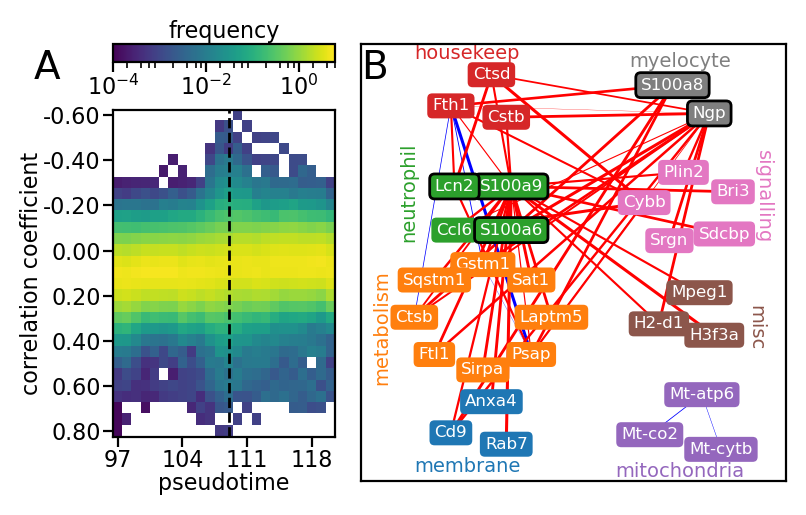

In [6]:
# In[95]:

print('making fig 6')

plt.style.reload_library()
plt.style.use('one_col_fig')

marg_ht = 1
leg_ht  = 1
leg_spc = 2
hist_ht = 15
grph_ex_ht = 2

marg_wd = 1
col1_wd = 10
spc_wd  = 1
col2_wd = 19

# row heights
hts = np.array([
    
    marg_ht,
    leg_ht,
    leg_spc,
    hist_ht,
    grph_ex_ht

])

wds = np.array([
    marg_wd,
    col1_wd,
    spc_wd,
    col2_wd,
])

rs = np.cumsum(hts) # starting rows
cs = np.cumsum(wds) # starting cols 

nr = np.sum(hts)
nc = np.sum(wds)

wid = 11.4 / 2.54 #17.8/2.54
ht  = wid*nr/nc

fig = plt.figure(figsize=(wid, ht), dpi=200) 

gs = gridspec.GridSpec(nr, nc)

axAL = plt.subplot( gs[rs[0]:rs[1],  cs[0]:cs[1]]) # corr hist heat map legend
axA  = plt.subplot( gs[rs[2]:rs[3], cs[0]:cs[1]]) # corr hist

axB  = plt.subplot( gs[rs[0]:, cs[2]:cs[3]])      # gene graph

caps = ['A','B']
ri   = [0,0]
ci   = [0,cs[2]]
ys   = [-0.5,-0.5]
xs   = [-3,0]
for i in range(len(caps)):
    cap_ax=plt.subplot(gs[ri[i]:ri[i]+1,ci[i]:ci[i]+1])
    cap_ax.text(s=caps[i], 
                x=xs[i],
                y=ys[i],fontsize=14,verticalalignment='top',horizontalalignment='left')
    cap_ax.axis('off')

#####################################
## A: correlation distribution   ####
#####################################

cmap = copy.copy(matplotlib.cm.get_cmap("viridis"))
cmap.set_bad('white')

hist_min = 1e-4
hist_max = 6
ti = ti

corr_hist_idxs = np.where((corr_bin_ctrs<0.85)&(corr_bin_ctrs>-0.6))[0]

im = axA.imshow(thresh_hists[:,corr_hist_idxs].T, cmap=cmap,aspect='auto',
                norm=matplotlib.colors.LogNorm(vmin=hist_min,vmax=hist_max))

axA.set_xlabel('pseudotime')
axA.set_ylabel('correlation coefficient')
tskip = 7
axA.set_xticks(np.arange(0,tf-ti,tskip))
axA.set_xticklabels(np.arange(ti,tf,tskip))
bskip = 4
# axA.set_yticks(np.arange(0,corr_bin_ctrs.shape[0],bskip))
# axA.set_yticklabels(['{0:.2f}'.format(i) for i in corr_bin_ctrs[::bskip]])
axA.set_yticks(np.arange(0,corr_hist_idxs.shape[0],bskip))
axA.set_yticklabels(['{0:.2f}'.format(i) for i in corr_bin_ctrs[corr_hist_idxs][::bskip]])
axA.axvline(bift-ti, linestyle='--',color='k')

cbar = fig.colorbar(im, cax=axAL, orientation='horizontal', aspect=1)
cbar.set_label('frequency',rotation=0,labelpad=2)
axAL.xaxis.set_label_position('top')

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=3) 
axAL.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=100)
axAL.xaxis.set_minor_locator(locmin)

#####################################
## B: gene graph                 ####
#####################################

bkg_col = 'bisque'
transf = axB.transData.inverted()

props    = dict(boxstyle='round', facecolor='white', alpha=1)
grp_bnds = np.zeros((len(gtypes),2,2))
grp_bnds[:,:,0] =  np.inf
grp_bnds[:,:,1] = -np.inf

xoffs = 0.035*np.array([-1,-1,-1,-1,
                       1,1,1,1])
#plot nodes, keep track of min and max position of group
for node in gnms_net.nodes():
    props['facecolor'] = gtxt_col_d[node]
    props['edgecolor'] = 'k' if node in weinreb_gnms else 'none'
    
    x,y = node_pos[node]
    m=axB.text(x,y, node.capitalize(), fontsize=6, bbox=props, color='white', #gtxt_col_d[node],
             horizontalalignment='center',verticalalignment='center', zorder=2)
    
rots = [0,90,90,0,0,270,270,0]
gtype_nms = ['membrane','metabolism', 'neutrophil','housekeep','mitochondria', 'misc', 'signalling', 'myelocyte']
gtxtx = np.array([ 0.25,        0.025,         0.09,       0.25,          0.75,   0.95,         0.97,      0.75])
gtxty = np.array([0.01,            0.35,       0.66,       1,             0,   0.35,         0.65,      0.98])
haligns = [    'center',      'left',       'left',   'center',      'center', 'right',     'right',  'center']
valigns = [    'bottom',    'center',     'center',      'top',      'bottom','center',    'center',     'top']

for i in range(len(gtypes)):
    
    axB.text(s = gtype_nms[i], x=gtxtx[i], y = gtxty[i], fontsize=7,#bbox=props,
        horizontalalignment=haligns[i],verticalalignment=valigns[i],rotation=rots[i],zorder=1, color=cols[i],
            transform=axB.transAxes)

xlims = [gxmin-gdx/6,gxmax+gdx/6]
ylims = [gymin-gdy/12,gymax+gdy/12]


axB.set_xlim(*xlims)
axB.set_ylim(*ylims)

# edges
for edge in gnms_net.edges:
    g0,g1 = edge
    x0,y0 = node_pos[g0]
    x1,y1 = node_pos[g1]
    axB.plot([x0,x1],[y0,y1], c=edge_cols_d[edge], lw = edge_widths_d[edge], zorder=1)
    
axB.set_xticks([])
axB.set_yticks([])

#plt.savefig('{0}/fig6_neut_corr.pdf'.format(figdir), bbox_inches='tight')

print('saved fig 6')

In [ ]:
# In[69]:

ti = 90
tf = npsts

gtype_gidxs = [[gidx_dict[gtype[k]] for k in range(len(gtype))] for gtype in gtypes]
gexp_hi_corr = []
for gidxs in gtype_gidxs:
    gexp_hi_corr.append([np.hstack([gexp_lil[neut_pst_cidxs[t],gidx].toarray() 
                   for gidx in gidxs])
                  for t in range(ti,tf)]
    )


# In[144]:


# first index is cc
# second index is pseudotime
# third is cell
# fourth is gene
thresh = 0
gexp_hi_corr_mu = [np.array([[mf.meanor0(gexp_t[gexp_t>thresh]) 
                              for gexp_t in gexp_hi_corr[i][t].T]
                             for t in range(tf-ti)])
                   for i in range(len(gexp_hi_corr))]
gexp_hi_corr_std = [np.array([[mf.stdor0(gexp_t[gexp_t>thresh]) 
                              for gexp_t in gexp_hi_corr[i][t].T]
                             for t in range(tf-ti)])
                   for i in range(len(gexp_hi_corr))]
gexp_hi_corr_sem = [np.array([[mf.semor0(gexp_t[gexp_t>thresh])
                              for gexp_t in gexp_hi_corr[i][t].T]
                             for t in range(tf-ti)])
                   for i in range(len(gexp_hi_corr))]


# In[28]:


evec1 = np.load('{0}/eig/dat_evec.npy'.format(datdir))[:,0]
hi_g_idx = np.unravel_index(np.argmax(np.abs(evec1)), evec1.shape)[1]
evec1_nn = (np.sign(evec1[:,hi_g_idx])*evec1.T).T




# In[160]:


nrow = 4
ncol = 2

type_cols = plt.cm.tab10.colors

ti = 90
tf = npsts
asp = 1.5
fig,axs = plt.subplots(nrow,ncol,figsize=(8.7/2.54,8.7/2.54*asp),dpi=200)
marks = ['o','s','^','v','x','D','+','*']
cols = plt.cm.tab20.colors
for i in range(nrow):
    
    for j in range(ncol):
        type_idx = j*nrow+3-i
        ax = axs[i,j]
        #cols = plt.cm.viridis(np.linspace(0,1,len(gtypes[type_idx])))

        for k in range(len(gtypes[type_idx])):
            gnm  = gtypes[type_idx][k]
            gidx = gidx_dict[gnm]
            dat  = mf.norm0to1(gexp_hi_corr_mu[type_idx][:,k],0)
            ax.plot(np.arange(ti,tf),dat, label=gnm, color = cols[k], marker=marks[k])
            
        ax.axvline(bift,color='k',linestyle='--')
        
        if j == 0:
            if i==2:
                ax.set_ylabel(r'gene expression (normalized)')
                ax.yaxis.set_label_coords(-0.2,1.1)

        else:
            ax.set_yticklabels([])
        
        if i == nrow-1:
            ax.set_xlabel('pseudotime')
        else:
            ax.set_xticklabels([])
    
        ax.set_title(gtype_nms[type_idx].replace('\n',' '),color = type_cols[type_idx])
        
        #mf.set_axs_fontsize(ax,20)
        nlcol = 1
        lloc = None
#         if len(gtypes[type_idx])>5:
#             nlcol=2
#             lloc = (0.27,0.5)
#         elif type_idx == 6:
#             lloc = (0.2,0.3)
        if type_idx==6:
            lloc=(0.74,0.14)
        elif type_idx== 1:
            lloc = (0.27,0.28)
            
            
        leg = ax.legend(labelspacing=0, ncol= nlcol,fontsize=6,frameon=False,handlelength=0.5,handletextpad=0,
                  columnspacing=2.5, loc=lloc,borderpad=0)
        for k,text in zip(range(len(gtypes[type_idx])),leg.get_texts()):
            plt.setp(text, color = cols[k])
        
plt.subplots_adjust(hspace=0.2,wspace=0.1)
plt.savefig('{0}/figS6_corr_graph_gexp.pdf'.format(figdir),bbox_inches = 'tight')
print('saved fig S6')

# In[141]: fig s6
print('making figure s7')


nrow = 4
ncol = 2

type_cols = plt.cm.tab10.colors


ti = 90
tf = npsts
asp = 1.5
fig,axs = plt.subplots(nrow,ncol,figsize=(8.7/2.54,8.7/2.54*asp),dpi=200)
marks = ['o','s','^','v','x','D','+','*']
cols = plt.cm.tab20.colors
for i in range(nrow):
    
    for j in range(ncol):
        type_idx = j*nrow+3-i
        ax = axs[i,j]
        #cols = plt.cm.viridis(np.linspace(0,1,len(gtypes[type_idx])))

        for k in range(len(gtypes[type_idx])):
            gnm  = gtypes[type_idx][k]
            gidx = gidx_dict[gnm]
            dat  = mf.norm0to1(evec1_nn[ti:tf, gidx]**2, 0)
            #dat  = evec1_nn[ti:tf, gidx]**2
            ax.plot(np.arange(ti,tf),dat, label=gnm, color = cols[k], marker=marks[k])
            
        ax.axvline(bift,color='k',linestyle='--')
        
        if j == 0:
            if i==2:
                ax.set_ylabel(r'fraction of pc1 $(|\vec{s}_1^{\,i}|^2)$ (normalized)')
                ax.yaxis.set_label_coords(-0.2,1.1)

        else:
            ax.set_yticklabels([])
        
        if i == nrow-1:
            ax.set_xlabel('pseudotime')
        else:
            ax.set_xticklabels([])
    
        ax.set_title(gtype_nms[type_idx].replace('\n',' '),color = type_cols[type_idx])
        
        #mf.set_axs_fontsize(ax,20)
        nlcol = 1
        lloc = None
        if len(gtypes[type_idx])>5:
            nlcol=2
            lloc = (0.27,0.5)
        elif type_idx == 6:
            lloc = (0.2,0.3)
            
        leg = ax.legend(labelspacing=0, ncol= nlcol,fontsize=6,frameon=False,handlelength=0.5,handletextpad=0,
                  columnspacing=2.5, loc=lloc)
        for k,text in zip(range(len(gtypes[type_idx])),leg.get_texts()):
            plt.setp(text, color = cols[k])
        
plt.subplots_adjust(hspace=0.2,wspace=0.1)
#plt.savefig('{0}/figS7_v1sq.pdf'.format(figdir),bbox_inches = 'tight')
print('saved fig S7')

making fig 6
saved fig 6


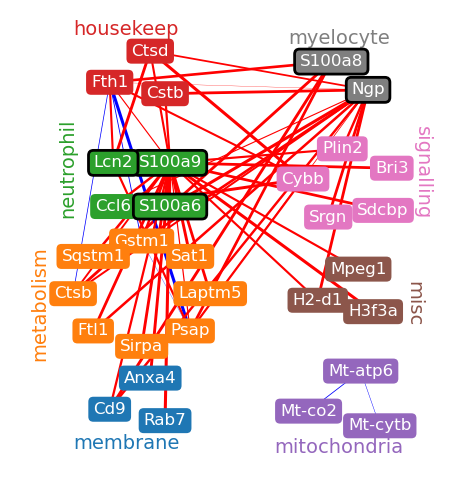

In [9]:
# just 6B
# In[95]:

print('making fig 6')

plt.style.reload_library()
plt.style.use('one_col_fig')

marg_ht = 1
leg_ht  = 1
leg_spc = 2
hist_ht = 15
grph_ex_ht = 2

marg_wd = 1
col1_wd = 10
spc_wd  = 1
col2_wd = 19

# row heights
hts = np.array([
    
    marg_ht,
    leg_ht,
    leg_spc,
    hist_ht,
    grph_ex_ht

])

wds = np.array([
    marg_wd,
    col1_wd,
    spc_wd,
    col2_wd,
])

rs = np.cumsum(hts) # starting rows
cs = np.cumsum(wds) # starting cols 

nr = np.sum(hts)
nc = np.sum(wds)

wid = 11.4 / 2.54 #17.8/2.54
ht  = wid*nr/nc

fig = plt.figure(figsize=(wid, ht), dpi=200) 

gs = gridspec.GridSpec(nr, nc)

axB  = plt.subplot( gs[rs[0]:, cs[2]:cs[3]])      # gene graph


#####################################
## B: gene graph                 ####
#####################################

bkg_col = 'bisque'
transf = axB.transData.inverted()

props    = dict(boxstyle='round', facecolor='white', alpha=1)
grp_bnds = np.zeros((len(gtypes),2,2))
grp_bnds[:,:,0] =  np.inf
grp_bnds[:,:,1] = -np.inf

xoffs = 0.035*np.array([-1,-1,-1,-1,
                       1,1,1,1])
#plot nodes, keep track of min and max position of group
for node in gnms_net.nodes():
    props['facecolor'] = gtxt_col_d[node]
    props['edgecolor'] = 'k' if node in weinreb_gnms else 'none'
    
    x,y = node_pos[node]
    m=axB.text(x,y, node.capitalize(), fontsize=6, bbox=props, color='white', #gtxt_col_d[node],
             horizontalalignment='center',verticalalignment='center', zorder=2)
    
rots = [0,90,90,0,0,270,270,0]
gtype_nms = ['membrane','metabolism', 'neutrophil','housekeep','mitochondria', 'misc', 'signalling', 'myelocyte']
gtxtx = np.array([ 0.25,        0.025,         0.09,       0.25,          0.75,   0.95,         0.97,      0.75])
gtxty = np.array([0.01,            0.35,       0.66,       1,             0,   0.35,         0.65,      0.98])
haligns = [    'center',      'left',       'left',   'center',      'center', 'right',     'right',  'center']
valigns = [    'bottom',    'center',     'center',      'top',      'bottom','center',    'center',     'top']

for i in range(len(gtypes)):
    
    axB.text(s = gtype_nms[i], x=gtxtx[i], y = gtxty[i], fontsize=7,#bbox=props,
        horizontalalignment=haligns[i],verticalalignment=valigns[i],rotation=rots[i],zorder=1, color=cols[i],
            transform=axB.transAxes)

xlims = [gxmin-gdx/6,gxmax+gdx/6]
ylims = [gymin-gdy/12,gymax+gdy/12]


axB.set_xlim(*xlims)
axB.set_ylim(*ylims)

# edges
for edge in gnms_net.edges:
    g0,g1 = edge
    x0,y0 = node_pos[g0]
    x1,y1 = node_pos[g1]
    axB.plot([x0,x1],[y0,y1], c=edge_cols_d[edge], lw = edge_widths_d[edge], zorder=1)
    
axB.set_xticks([])
axB.set_yticks([])
axB.axis('off')

plt.savefig('{0}/fig6B.jpg'.format(figdir), bbox_inches='tight')

print('saved fig 6')